# AMICI documentation example of the steady state solver logic

This is an example to document the internal logic of the steady state solver, which is used in preequilibration and postequilibration.

## Steady states of dynamical system

Not every dynamical system needs to run into a steady state. Instead, it may exhibit

  * continuous growth, e.g., $$\dot{x} = x, \quad x_0 = 1$$
  * a finite-time blow up, e.g., $$\dot{x} = x^2, \quad x_0 = 1$$
  * oscillations, e.g., $$\ddot{x} = -x, \quad x_0 = 1$$
  * chaotic behaviour, e.g., the Lorentz attractor

If the considered dynamical system has a steady state for positive times, then integrating the ODE long enough will equilibrate the system to this steady state. However, this may be computationally more demanding than other approaches and may fail, if the maximum number of integration steps is exceeded before reaching the steady state.

In general, Newton's method will find the steady state faster than forward simulation. However, it only converges if started close enough to the steady state. Moreover, it will not work, if the dynamical system has conserved quantities which were not removed prior to steady state computation: Conserved quantities will cause singularities in the Jacobian of the right hand side of the system, such that the linear problem within each step of Newton's method can not be solved.

## Logic of the steady state solver

If AMICI has to equilibrate a dynamical system, it can do this either via simulating until the right hand side of the system becomes small, or it can try to find the steady state directly by Newton's method.
Amici decides automatically which approach is chosen and how forward or adjoint sensitivities are computed, if requested. However, the user can influence this behavior, if prior knowledge about the dynamical is available.

The logic which AMICI will follow to equilibrate the system works as follows:

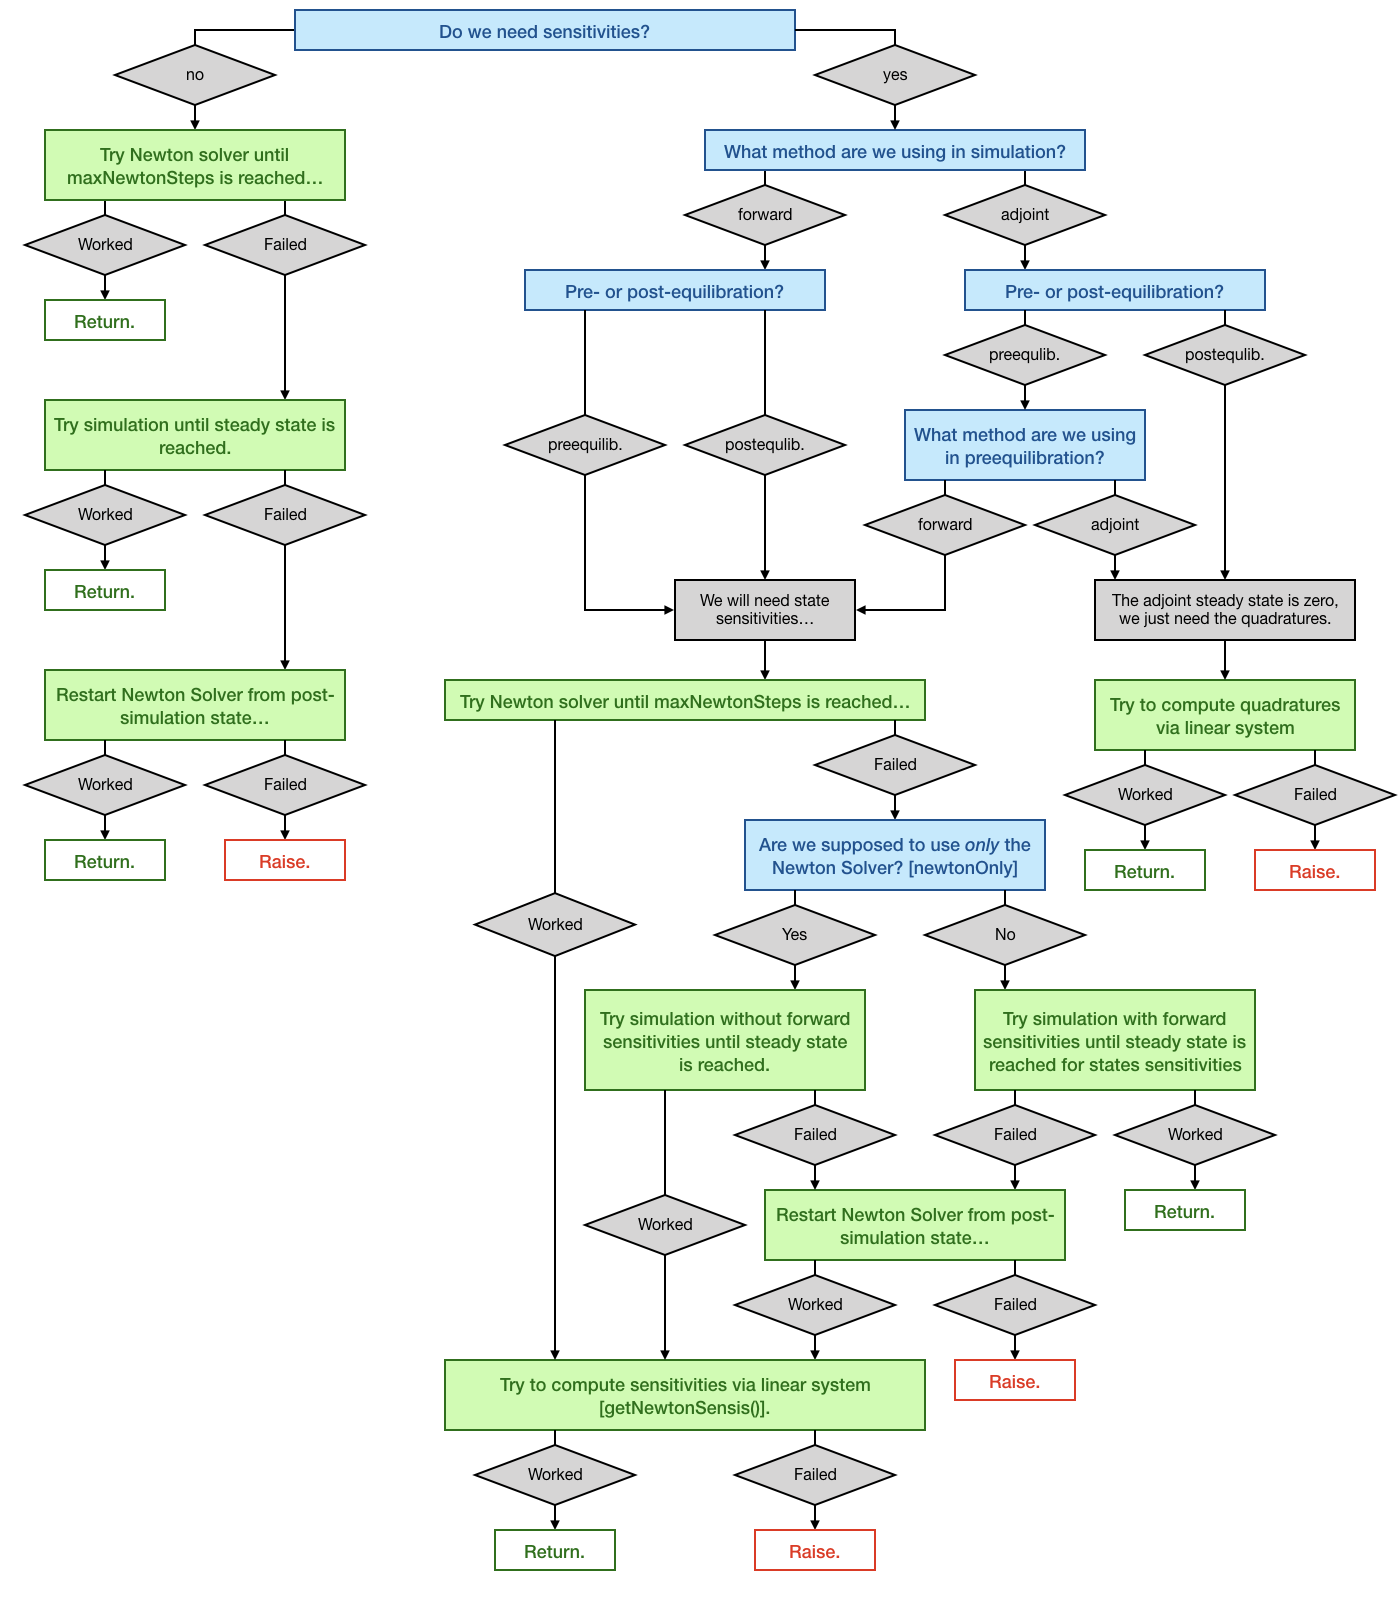

In [1]:
from IPython.display import Image
fig = Image(filename=('../../../documentation/gfx/steadystate_solver_workflow.png'))
fig

## The example model

We will use the example model `model_constant_species.xml`, which has conserved species. Those are automatically removed in the SBML import of AMICI, but they can also be kept in the model to demonstrate the failure of Newton's method due to a singular right hand side Jacobian.

In [2]:
import libsbml
import importlib
import amici
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# SBML model we want to import
sbml_file = 'model_constant_species.xml'

# Name of the models that will also be the name of the python module
model_name = 'model_constant_species'
model_reduced_name = model_name + '_reduced'

# Directories to which the generated model code is written
model_output_dir = model_name
model_reduced_output_dir = model_reduced_name

# Read the model and give some output
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()
dir(sbml_doc)

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(),
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))

Species:  ['substrate', 'enzyme', 'complex', 'product']

Reactions:
creation:             -> substrate		[compartment * (synthesis_substrate + k_create)]
binding:  substrate +  enzyme <->   complex		[compartment * (k_bind * substrate * enzyme - k_unbind * complex)]
conversion:    complex  -> enzyme +  product		[compartment * k_convert * complex]
decay:    product  ->          		[compartment * k_decay * product]


In [3]:
# Create an SbmlImporter instance for our SBML model
sbml_importer = amici.SbmlImporter(sbml_file)

# specify observables and constant parameters
constantParameters = ['synthesis_substrate', 'init_enzyme']
observables = {
    'observable_product': {'name': '', 'formula': 'product'},
    'observable_substrate': {'name': '', 'formula': 'substrate'},
}
sigmas = {'observable_product': 1.0, 'observable_substrate': 1.0}

# import the model
sbml_importer.sbml2amici(model_reduced_name,
                         model_reduced_output_dir,
                         observables=observables,
                         constantParameters=constantParameters,
                         sigmas=sigmas)
sbml_importer.sbml2amici(model_name,
                         model_output_dir,
                         observables=observables,
                         constantParameters=constantParameters,
                         sigmas=sigmas,
                         compute_conservation_laws=False)

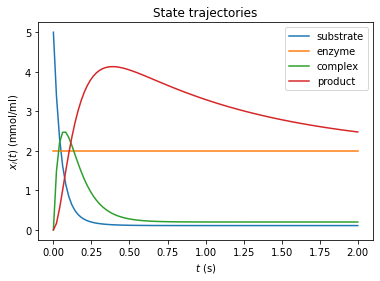

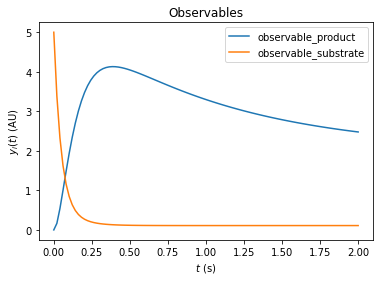

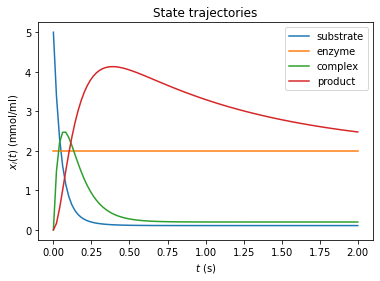

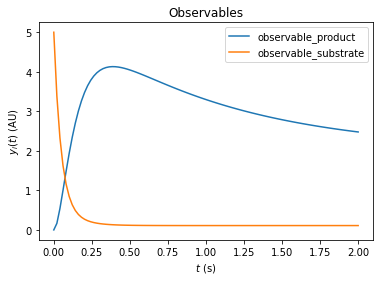

In [4]:
# import the models and run some test simulations
model_reduced_module = amici.import_model_module(model_reduced_name, os.path.abspath(model_reduced_output_dir))
model_reduced = model_reduced_module.getModel()

model_module = amici.import_model_module(model_name, os.path.abspath(model_output_dir))
model = model_module.getModel()


# simulate model with conservation laws
model_reduced.setTimepoints(np.linspace(0, 2, 100))
solver_reduced = model_reduced.getSolver()
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

# simulate model without conservation laws
model.setTimepoints(np.linspace(0, 2, 100))
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

# plot trajectories
import amici.plotting
amici.plotting.plotStateTrajectories(rdata_reduced, model=model_reduced)
amici.plotting.plotObservableTrajectories(rdata_reduced, model=model_reduced)

amici.plotting.plotStateTrajectories(rdata, model=model)
amici.plotting.plotObservableTrajectories(rdata, model=model)

## Inferring the steady state of the system (postequilibration)

First, we want to demonstrate that Newton's method will fail with the unreduced model due to a singular right hand side Jacobian.

In [5]:
# Call postequilibration by setting an infinity timepoint
model.setTimepoints(np.full(1, np.inf))

# set the solver
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setMaxSteps(1000)
rdata = amici.runAmiciSimulation(model, solver)

#np.set_printoptions(threshold=8, edgeitems=2)
for key, value in rdata.items():
    print('%12s: ' % key, value)

          ts:  [inf]
           x:  [[0.11       2.         0.2        2.00000002]]
          x0:  [5. 2. 0. 0.]
        x_ss:  [nan nan nan nan]
          sx:  None
         sx0:  None
       sx_ss:  None
           y:  [[2.00000002 0.11      ]]
      sigmay:  [[1. 1.]]
          sy:  None
     ssigmay:  None
           z:  None
          rz:  None
      sigmaz:  None
          sz:  None
         srz:  None
     ssigmaz:  None
        sllh:  None
       s2llh:  None
           J:  [[-20.    0.   20.    0. ]
 [ -1.1   0.    1.1   0. ]
 [  1.    0.  -11.   10. ]
 [  0.    0.    0.   -1. ]]
        xdot:  [ 0.00000000e+00  0.00000000e+00  2.22044605e-16 -2.24170307e-08]
      status:  0.0
         llh:  nan
        chi2:  nan
         res:  [0. 0.]
        sres:  None
         FIM:  None
           w:  [[2.         2.         2.         2.00000002]]
  preeq_wrms:  nan
     preeq_t:  nan
preeq_numlinsteps:  None
preeq_numsteps:  [[0 0 0]]
preeq_numstepsB:  12.0
preeq_status:  [[0 0 0]]
pr

The fields `posteq_status` and `posteq_numsteps` in rdata tells us how postequilibration worked:

  * the first entry informs us about the status/number of steps in Newton's method (here 0, as Newton's method did not work)
  * the second entry tells us, the status/how many integration steps were taken until steady state was reached
  * the third entry informs us about the status/number of Newton steps in the second launch, after simulation

The status is encoded as an Integer flag with the following meanings:

  * ` 1`: Successful run
  * ` 0`: Did not run
  * `-1`: Error: No further specification is given, the error message should give more information.
  * `-2`: Error: The method did not converge to a steady state within the maximum number of steps (Newton's method or simulation).
  * `-3`: Error: The Jacobian of the right hand side is singular (only Newton's method)
  * `-4`: Error: The damping factor in Newton's method was reduced until it met the lower bound without success (Newton's method only)
  * `-5`: Error: The model was simulated past the timepoint `t=1e100` without finding a steady state. Therefore, it is likely that the model has not steady state for the given parameter vector.

Here, only the second entry of `posteq_status` contains a positive integer: The first run of Newton's method failed due to a Jacobian, which oculd not be factorized, but the second run (simulation) contains the entry 1 (success). The third entry is 0, thus Newton's method was not launched for a second time.
More information can be found in`posteq_numsteps`: Also here, only the second entry contains a positive integer, which is smaller than the maximum number of steps taken (<1000). Hence steady state was reached via simulation, which corresponds to the simulated time written to `posteq_time`.

We want to demonstrate a complete failure if inferring the steady state by reducing the number of integration steps to a lower value:

In [6]:
# reduce maxsteps for integration
solver.setMaxSteps(100)
rdata = amici.runAmiciSimulation(model, solver)
print('Status of postequilibration:', rdata['posteq_status'])
print('Number of steps employed in postequilibration:', rdata['posteq_numsteps'])

Status of postequilibration: [[-3 -2 -3]]
Number of steps employed in postequilibration: [[  0 100   0]]


[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: RHS could not be factorized. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: RHS could not be factorized.
Error occured in:
0          0x1060f7913 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x1060f6b3c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x1060f6882 amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 322
3          0x1060a4615 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 405
4  


However, the same logic works, if we use the reduced model.
For sufficiently many Newton steps, postequilibration is achieved by Newton's method in the first run. In this specific example, the steady state is found within one step.

In [7]:
# Call postequilibration by setting an infinity timepoint
model_reduced.setTimepoints(np.full(1, np.inf))

# set the solver
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setMaxSteps(100)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

print('Status of postequilibration:', rdata_reduced['posteq_status'])
print('Number of steps employed in postequilibration:', rdata_reduced['posteq_numsteps'])

Status of postequilibration: [[1 0 0]]
Number of steps employed in postequilibration: [[2 0 0]]


## Postequilibration with sensitivities

Equilibration is possible with forward and adjoint sensitivity analysis. As for the main simulation part, adjoint sensitivity analysis yields less information than forward sensitivity analysis, since no state sensitivities are computed. However, it has a better scaling behavior towards large model sizes.

### Postequilibration with forward sensitivities

If forward sensitivity analysis is used, then state sensitivities at the timepoint `np.inf` will be computed. This can be done in (currently) two different ways:

1. If the Jacobian $\nabla_x f$ of the right hand side $f$ is not (close to) singular, the most efficient approach will be solving the linear system of equations, which defines the steady state sensitivities:

   $$0 = \dot{s}^x = (\nabla_x f) s^x + \frac{\partial f}{\partial \theta}\qquad \Rightarrow \qquad(\nabla_x f) s^x = - \frac{\partial f}{\partial \theta}$$

   This approach will always be chosen by AMICI, if the option `model.SteadyStateSensitivityMode` is set to `SteadyStateSensitivityMode.newtonOnly`. Furthermore, it will also be chosen, if the steady state was found by Newton's method, as in this case, the Jacobian is at least not singular (but may still be poorly conditioned). A check for the condition number of the Jacobian is currently missing, but will soon be implemented.

2. If the Jacobian is poorly conditioned or singular, then the only way to obtain a reliable result will be integrating the state variables with state sensitivities until the norm of the right hand side becomes small. This approach will be chosen by AMICI, if the steady state was found by simulation and the option `model.SteadyStateSensitivityMode` is set to `SteadyStateSensitivityMode.simulationFSA`. This approach is numerically more stable, but the computation time for large models may be substantial.

Side remark:

A possible third way may consist in a (relaxed) Richardson iteration type approach, which interprets the entries of the right hand side $f$ as residuals and minimizes the squared residuals $\Vert f \Vert^2$ by a Levenberg-Marquart-type algorithm. This approach would also work for poorly conditioned (and even for singular Jacobians if additional constraints are implemented as Lagrange multipliers) while being faster than a long forward simulation.

We want to demonstrate both possibilities to find the steady state sensitivities, as well as the failure of their computation if the Jacobian is singular and the `newtonOnly` setting was used.

In [8]:
# Call simulation with singular Jacobian and simulationFSA mode
model.setTimepoints(np.full(1, np.inf))
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.simulationFSA)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
solver.setMaxSteps(10000)
rdata = amici.runAmiciSimulation(model, solver)

print('Status of postequilibration:', rdata['posteq_status'])
print('Number of steps employed in postequilibration:', rdata['posteq_numsteps'])
print('Computed state sensitivities:')
print(rdata['sx'][0,:,:])

Status of postequilibration: [[-3  1  0]]
Number of steps employed in postequilibration: [[   0 1026    0]]
Computed state sensitivities:
[[-1.10000000e-02  0.00000000e+00 -6.70507402e-18 -1.20114408e-11]
 [ 1.00000000e-02  0.00000000e+00 -8.22965063e-19  1.20114329e-11]
 [-1.00000000e-03  0.00000000e+00 -2.00000000e-02 -2.40228711e-11]
 [ 5.50000000e-02  0.00000000e+00  1.00000000e-01  9.99999999e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.00000004e+00]]


In [9]:
# Call simulation with singular Jacobian and newtonOnly mode (will fail)
model.setTimepoints(np.full(1, np.inf))
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver = model.getSolver()
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
solver.setMaxSteps(10000)
rdata = amici.runAmiciSimulation(model, solver)

print('Status of postequilibration:', rdata['posteq_status'])
print('Number of steps employed in postequilibration:', rdata['posteq_numsteps'])
print('Computed state sensitivities:')
print(rdata['sx'][0,:,:])

Status of postequilibration: [[-2 -1  1]]
Number of steps employed in postequilibration: [[  0 543   0]]
Computed state sensitivities:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitvitiy computation failed due to unsuccessful factorization of RHS Jacobian
Error occured in:
0          0x1060f698b amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 587
1          0x1060a4615 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 405
2          0x1060a4474 amici::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 36
3          0x106061005 _wrap_runAmiciSimulation(_object*, _object*) + 549
4          0x1021b2309 cfunction_call_varargs + 320
5          


In [10]:
# Call postequilibration by setting an infinity timepoint
model_reduced.setTimepoints(np.full(1, np.inf))
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.forward)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
solver_reduced.setMaxSteps(1000)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced)

print('Status of postequilibration:', rdata_reduced['posteq_status'])
print('Number of steps employed in postequilibration:', rdata_reduced['posteq_numsteps'])
print('Computed state sensitivities:')
print(rdata_reduced['sx'][0,:,:])

Status of postequilibration: [[1 0 0]]
Number of steps employed in postequilibration: [[2 0 0]]
Computed state sensitivities:
[[-1.1e-02  0.0e+00 -0.0e+00 -0.0e+00]
 [ 1.0e-02  0.0e+00 -0.0e+00 -0.0e+00]
 [-1.0e-03  0.0e+00 -2.0e-02 -0.0e+00]
 [ 5.5e-02  0.0e+00  1.0e-01  1.0e+00]
 [-0.0e+00  0.0e+00 -0.0e+00 -2.0e+00]]


### Postequilibration with adjoint sensitivities

Postequilibration also works with adjoint sensitivities. In this case, it is exploited that the ODE of the adjoint state $p$ will always have the steady state 0, since it's a linear ODE:
$$\frac{d}{dt} p(t) = J(x^*, \theta)^T p(t)$$
where $x^*$ denotes the steady state of the system state.
Since the Eigenvalues of the Jacobian are negative and since the Jacobian at steady state is a fixed matrix, this system has a simple algebraic solution:
$$p(t) = e^{t J(x^*, \theta)^T} p_{\text{end}}$$. As a consequence, the quadratures in adjoint computation also reduce to a matrix-vector product:
$$Q(x, \theta) = Q(x^*, \theta) = p_{\text{integral}} * \frac{\partial f}{\partial \theta}$$
with
$$p_{\text{integral}} = \int_0^\infty p(s) ds = (J(x^*, \theta)^T)^{-1} p_{\text{end}}$$. However, this solution is given in terms of a linear system of equations defined by the transposed Jacobian of the right hand side. Hence, if the (transposed) Jacobian is singular, it is not applicable.
In this case, standard integration must be carried out.

In [11]:
# Call adjoint postequilibration by setting an infinity timepoint
# and create an edata object, which is needed for adjoint computation
edata = amici.ExpData(2, 0, 0, np.array([float('inf')]))
edata.setObservedData([1.8] * 2)
edata.fixedParameters = np.array([3., 5.])

model_reduced.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
solver_reduced.setMaxSteps(1000)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

print('Status of postequilibration:', rdata_reduced['posteq_status'])
print('Number of steps employed in postequilibration:', rdata_reduced['posteq_numsteps'])
print('Number of backward steps employed in postequilibration:', rdata_reduced['posteq_numstepsB'])
print('Computed gradient:', rdata_reduced['sllh'])

Status of postequilibration: [[1 0 0]]
Number of steps employed in postequilibration: [[2 0 0]]
Number of backward steps employed in postequilibration: 0.0
Computed gradient: [-1.85900e-02  1.69000e-02 -1.69000e-03 -3.16282e+00  1.60000e+01]


If we carry out the same computation with a system that has a singular Jacobian, then `posteq_numstepsB` will not be `0` any more (which indicates that the linear system solve was used to compute backward postequilibration).
Now, integration is carried out and hence `posteq_numstepsB > 0`

In [12]:
# Call adjoint postequilibration with model with singular Jacobian
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
rdata = amici.runAmiciSimulation(model, solver, edata)

print('Status of postequilibration:', rdata['posteq_status'])
print('Number of steps employed in postequilibration:', rdata['posteq_numsteps'])
print('Number of backward steps employed in postequilibration:', rdata['posteq_numstepsB'])
print('Computed gradient:', rdata['sllh'])

Status of postequilibration: [[-3 -1  1]]
Number of steps employed in postequilibration: [[  0 479   0]]
Number of backward steps employed in postequilibration: 3076.0
Computed gradient: [-1.85899987e-02  1.68999988e-02 -1.69000055e-03 -3.16282001e+00
  1.60000000e+01]


## Preequilibrating the model

Sometimes, we want to launch a solver run from a steady state which was inferred numerically, i.e., the system was preequilibrated. In order to do this with AMICI, we need to pass an ExpData object, which contains fixed parameter for the actual simulation and for preequilibration of the model.

In [13]:
# create edata, with 3 timepoints and 2 observables:
edata = amici.ExpData(2, 0, 0,
                      np.array([0., 0.1, 1.]))
edata.setObservedData([1.8] * 6)
edata.fixedParameters = np.array([3., 5.])
edata.fixedParametersPreequilibration = np.array([0., 2.])
edata.reinitializeFixedParameterInitialStates = True

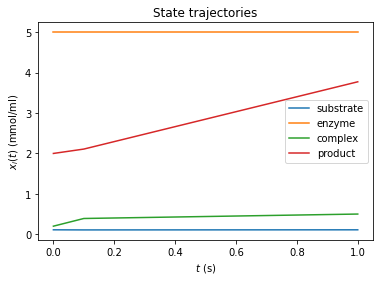

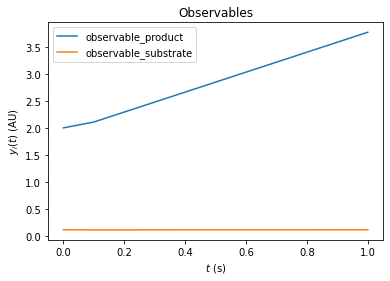

In [14]:
# create the solver object and run the simulation
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

amici.plotting.plotStateTrajectories(rdata_reduced, model = model_reduced)
amici.plotting.plotObservableTrajectories(rdata_reduced, model = model_reduced)

We can also combine pre- and postequilibration.

In [15]:
# Change the last timepoint to an infinity timepoint.
edata.setTimepoints(np.array([0., 0.1, float('inf')]))

# run the simulation
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

## Preequilibration with sensitivities

Beyond the need for an ExpData object, the steady state solver logic in preequilibration is the same as in postequilibration, also if sensitivities are requested. The computation will fail for singular Jacobians, if `SteadyStateSensitivityMode` is set to `newtonOnly`, or if not enough steps can be taken.
However, if forward simulation with steady state sensitivities is allowed, or if the Jacobian is not singular, it will work.

### Prequilibration with forward sensitivities

In [16]:
# No postquilibration this time.
edata.setTimepoints(np.array([0., 0.1, 1.]))

# create the solver object and run the simulation, singular Jacobian, enforce Newton solver for sensitivities
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.newtonOnly)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
rdata = amici.runAmiciSimulation(model, solver, edata)

for key, value in rdata.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)

          preeq_wrms:  0.5604257578208488
             preeq_t:  19.2252094591474
   preeq_numlinsteps:  None
      preeq_numsteps:  [[  0 417   0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[-3  1  0]]
      preeq_cpu_time:  1.723
     preeq_cpu_timeB:  0.0


[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitvitiy computation failed due to unsuccessful factorization of RHS Jacobian
Error occured in:
0          0x1060f698b amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 587
1          0x1060a456f amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 239
2          0x1060a4474 amici::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 36
3          0x106061005 _wrap_runAmiciSimulation(_object*, _object*) + 549
4          0x1021b2309 cfunction_call_varargs + 320
5          


In [17]:
# Singluar Jacobian, use simulation
model.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.simulationFSA)
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.forward)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
rdata = amici.runAmiciSimulation(model, solver, edata)

for key, value in rdata.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)

          preeq_wrms:  0.9920376238481097
             preeq_t:  21.270502326483026
   preeq_numlinsteps:  None
      preeq_numsteps:  [[   0 1026    0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[-3  1  0]]
      preeq_cpu_time:  12.439
     preeq_cpu_timeB:  0.0


In [18]:
# Non-singular Jacobian, use Newton solver
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.forward)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

for key, value in rdata_reduced.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)

          preeq_wrms:  0.0
             preeq_t:  nan
   preeq_numlinsteps:  None
      preeq_numsteps:  [[2 0 0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[1 0 0]]
      preeq_cpu_time:  0.036
     preeq_cpu_timeB:  0.0


### Prequilibration with adjoint sensitivities


When using preequilibration, adjoint sensitivity analysis can be used for simulation. This is a particularly interesting case: Standard adjoint sensitivity analysis requires the initial state sensitivities `sx0` to work, at least if data is given for finite (i.e., not exclusively postequilibration) timepoints:
For each parameter, a contribution to the gradient is given by the scalar product of the corresponding state sensitivity vector at timepoint $t=0$, (column in `sx0`), with the adjoint state ($p(t=0)$). Hence, the matrix `sx0` is needed. This scalar product "closes the loop" from forward to adjoint simulation.

By default, if adjoint sensitivity analysis is called with preequilibration, the initial state sensitivities are computed in just the same way as if this way done for forward sensitivity analysis. The only difference in the internal logic is that, if the steady state gets inferred via simulation, a separate solver object is used in order to ensure that the steady state simulation does not interfere with the snapshotting of the forward trajectory from the actual time course.

However, also an adjoint version of preequilibration is possible: In this case, the "loop" from forward to adjoint simulation needs no closure: The simulation time is extended by preequilibration: forward from $t = -\infty$ to $t=0$, and after adjoint simulation also backward from $t=0$ to $t = -\infty$. Similar to adjoint postequilibration, the steady state of the adjoint state (at $t=-\infty$) is $p=0$, hence the scalar product (at $t=-\infty$) for the initial state sensitivities of preequilibration with the adjoint state vanishes. Instead, this gradient contribution is covered by additional quadratures $\int_{-\infty}^0 p(s) ds \cdot \frac{\partial f}{\partial \theta}$. In order to compute these quadratures correctly, the adjoint state from the main adjoint simulation must be passed on to the initial adjoint state of backward preequilibration.

However, as the adjoint state must be passed on from backward computation to preequilibration, it is currently not allowed to alter (reinitialize) states of the model at $t=0$, unless these states are constant, as otherwise this alteration would lead to a discontinuity in the adjoints state as well and hence to an incorrect gradient.

In [19]:
# Non-singular Jacobian, use Newton solver and adjoints with initial state sensitivities
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

for key, value in rdata_reduced.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)
print('Gradient:', rdata_reduced['sllh'])

          preeq_wrms:  0.0
             preeq_t:  nan
   preeq_numlinsteps:  None
      preeq_numsteps:  [[2 0 0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[1 0 0]]
      preeq_cpu_time:  0.039
     preeq_cpu_timeB:  0.0
Gradient: [-0.05528395  0.0461776  -0.03354519 -2.34602219  6.314481  ]


In [20]:
# Non-singular Jacobian, use simulation solver and adjoints with initial state sensitivities
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(0)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

for key, value in rdata_reduced.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)
print('Gradient:', rdata_reduced['sllh'])

          preeq_wrms:  0.8470065245264354
             preeq_t:  19.213162474372176
   preeq_numlinsteps:  None
      preeq_numsteps:  [[  0 426   0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[-2  1  0]]
      preeq_cpu_time:  1.753
     preeq_cpu_timeB:  0.0
Gradient: [-0.05528395  0.0461776  -0.03354519 -2.34602226  6.3144812 ]


In [21]:
# Non-singular Jacobian, use Newton solver and adjoints with fully adjoint preequilibration
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(10)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityMethodPreequilibration(amici.SensitivityMethod.adjoint)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)
rdata_reduced = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

for key, value in rdata_reduced.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)
print('Gradient:', rdata_reduced['sllh'])

          preeq_wrms:  0.0
             preeq_t:  nan
   preeq_numlinsteps:  None
      preeq_numsteps:  [[2 0 0]]
     preeq_numstepsB:  0.0
        preeq_status:  [[1 0 0]]
      preeq_cpu_time:  0.042
     preeq_cpu_timeB:  0.009
Gradient: [-0.05528395  0.0461776  -0.03354519 -2.34602219  6.314481  ]


As for postquilibration, adjoint preequilibration has an analytic solution (via the linear system), which will be preferred. If used for models with singular Jacobian, numerical integration will be carried out, which is indicated by `preeq_numstepsB`.

In [22]:
# Non-singular Jacobian, use Newton solver and adjoints with fully adjoint preequilibration
solver = model.getSolver()
solver.setNewtonMaxSteps(10)
solver.setSensitivityMethod(amici.SensitivityMethod.adjoint)
solver.setSensitivityMethodPreequilibration(amici.SensitivityMethod.adjoint)
solver.setSensitivityOrder(amici.SensitivityOrder.first)
rdata = amici.runAmiciSimulation(model, solver, edata)

for key, value in rdata.items():
    if key[0:6] == 'preeq_':
        print('%20s: ' % key, value)
print('Gradient:', rdata['sllh'])

          preeq_wrms:  0.9986067660342685
             preeq_t:  36.94272314329062
   preeq_numlinsteps:  None
      preeq_numsteps:  [[  0 417   0]]
     preeq_numstepsB:  1371.0
        preeq_status:  [[-3  1  0]]
      preeq_cpu_time:  2.488
     preeq_cpu_timeB:  5.016
Gradient: [-0.05528395  0.04617759 -0.03354518 -2.34602224  6.3144811 ]


## Controlling the error tolerances in pre- and postequilibration

When solving ODEs or DAEs, AMICI uses the default logic of CVODES and IDAS to control error tolerances. This means that error weights are computed based on the absolute error tolerances and the product of current state variables of the system and their respective relative error tolerances. If this error combination is then controlled.

The respective tolerances for equilibrating a system with AMICI can be controlled by the user via the getter/setter functions `[get|set][Absolute|Relative]ToleranceSteadyState[Sensi]`:

In [23]:
# Non-singular Jacobian, use simulaiton
model_reduced.setSteadyStateSensitivityMode(amici.SteadyStateSensitivityMode.simulationFSA)
solver_reduced = model_reduced.getSolver()
solver_reduced.setNewtonMaxSteps(0)
solver_reduced.setSensitivityMethod(amici.SensitivityMethod.forward)
solver_reduced.setSensitivityOrder(amici.SensitivityOrder.first)

# run with lax tolerances
solver_reduced.setRelativeToleranceSteadyState(1e-2)
solver_reduced.setAbsoluteToleranceSteadyState(1e-3)
solver_reduced.setRelativeToleranceSteadyStateSensi(1e-2)
solver_reduced.setAbsoluteToleranceSteadyStateSensi(1e-3)
rdata_reduced_lax = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

# run with strict tolerances
solver_reduced.setRelativeToleranceSteadyState(1e-12)
solver_reduced.setAbsoluteToleranceSteadyState(1e-16)
solver_reduced.setRelativeToleranceSteadyStateSensi(1e-12)
solver_reduced.setAbsoluteToleranceSteadyStateSensi(1e-16)
rdata_reduced_strict = amici.runAmiciSimulation(model_reduced, solver_reduced, edata)

# compare ODE outputs
print('\nODE solver steps, which were necessary to reach steady state:')
print('lax tolerances: ', rdata_reduced_lax['preeq_numsteps'])
print('strict tolerances: ', rdata_reduced_strict['preeq_numsteps'])

print('\nsimulation time corresponding to steady state:')
print(rdata_reduced_lax['preeq_t'])
print(rdata_reduced_strict['preeq_t'])

print('\ncomputation time to reach steady state:')
print(rdata_reduced_lax['preeq_cpu_time'])
print(rdata_reduced_strict['preeq_cpu_time'])


ODE solver steps, which were necessary to reach steady state:
lax tolerances:  [[  0 733   0]]
strict tolerances:  [[   0 1031    0]]

simulation time correpsonding to steady state:
6.002011407974004
31.0689293433781

computation time to reach steady state:
7.646
7.837
